In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
from theano import shared
%matplotlib inline
from sklearn.cross_validation import train_test_split
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from scipy import optimize
import regex as re


In [2]:
df = pd.read_csv('../other/frac_merge_peak.csv')


In [3]:
df['XEC_FIELD_Code'] = pd.Categorical(df['XEC_FIELD']).codes
df['Reservoir_Code'] = pd.Categorical(df['Reservoir']).codes


In [4]:
df.columns


Index([u'PropID', u'RSID', u'End_Date', u'Reservoir', u'Completed_Feet',
       u'#_of_Stages', u'Stage_Length', u'Clusters/Stage', u'Cluster_Spacing',
       u'Perfs/Cluster', u'Fluid_Bbls', u'Fluid_Gal/Ft', u'Fluid_Gal/Cluster',
       u'Fluid_Gal/Perf', u'Prop_Lbs', u'Prop_Lbs/Ft', u'Prop_Lbs/Cluster',
       u'Prop_Lbs/Perf', u'Avg_Prop_Conc', u'Max_Prop_Conc', u'Avg_Rate',
       u'Max_Rate', u'Rate/Ft', u'Rate/Cluster', u'Rate/Perf', u'Avg_Pressure',
       u'Max_Pressure', u'ISIP/Ft', u'5"_SIP/Ft', u'PROPNUM', u'XEC_FIELD',
       u'OPERATOR', u'COUNTY', u'STATE', u'M_LATITUDE', u'M_LONGITUDE',
       u'MAJOR', u'SPUD_DATE', u'FIRST_PROD', u'Wet_Gas_EUR', u'Dry_Gas_EUR',
       u'Oil_EUR', u'NGL_EUR', u'Days_Production', u'OIL_Peak',
       u'OIL_Days_to_Peak', u'XEC_FIELD_Code', u'Reservoir_Code'],
      dtype='object')

In [5]:
df.groupby(['XEC_FIELD', 'XEC_FIELD_Code'])['XEC_FIELD'].count()


XEC_FIELD        XEC_FIELD_Code
COTTONWOOD DRAW  0                 14
DIXIELAND        1                 47
FORD, WEST       2                 91
GRISHAM          3                  9
PHANTOM          4                  7
RED HILLS        5                  1
STATELINE        6                  3
TWO GEORGES      7                  6
Name: XEC_FIELD, dtype: int64

In [6]:
df.groupby(['Reservoir', 'Reservoir_Code'])['Reservoir'].count()


Reservoir         Reservoir_Code
Wolfcamp Shale A  0                 89
Wolfcamp Shale C  1                 14
Wolfcamp Shale D  2                 75
Name: Reservoir, dtype: int64

In [7]:
X = df[[u'Clusters/Stage', u'Perfs/Cluster', u'#_of_Stages', u'ISIP/Ft', u'Rate/Ft', u'Rate/Perf', u'Avg_Prop_Conc', 
        u'Max_Prop_Conc', u'Rate/Cluster', u'Max_Rate', u'Cluster_Spacing', u'Avg_Pressure', u'Prop_Lbs/Ft', 
        u'Prop_Lbs/Perf', u'Max_Pressure', u'Fluid_Gal/Perf', u'Fluid_Gal/Ft', u'Prop_Lbs/Cluster', 
        u'Fluid_Gal/Cluster', u'XEC_FIELD_Code', u'Reservoir_Code']]
y = df[[u'OIL_Peak']]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train.shape


(133, 21)

In [8]:
def standardize_2sd(df):
    return (df - df.mean(0)) / (2 * df.std(0))

def standardize_2sd_test(df_test, df_train):
    return (df_test - df_train.mean(0)) / (2 * df_train.std(0))


In [9]:
X_OLS_train = sm.add_constant(standardize_2sd(X_train.drop([u'XEC_FIELD_Code', u'Reservoir_Code'], axis=1)))
model = sm.OLS(y_train, X_OLS_train)
model = model.fit()
print model.summary()


                            OLS Regression Results                            
Dep. Variable:               OIL_Peak   R-squared:                       0.535
Model:                            OLS   Adj. R-squared:                  0.457
Method:                 Least Squares   F-statistic:                     6.851
Date:                Tue, 08 Nov 2016   Prob (F-statistic):           1.14e-11
Time:                        17:27:04   Log-Likelihood:                -881.57
No. Observations:                 133   AIC:                             1803.
Df Residuals:                     113   BIC:                             1861.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
const               615.9413     17.21

In [10]:
model = LinearRegression(fit_intercept=True, normalize=False)
model.fit(X_OLS_train.drop('const', axis=1), y_train)
print 'Train R2: {0}'.format(model.score(X_OLS_train.drop('const', axis=1), y_train))
X_OLS_test = standardize_2sd_test(X_test.drop([u'XEC_FIELD_Code', u'Reservoir_Code'], axis=1), 
                                        X_train.drop([u'XEC_FIELD_Code', u'Reservoir_Code'], axis=1))
print 'Test R2: {0}'.format(model.score(X_OLS_test, y_test))


Train R2: 0.53531511995
Test R2: 0.186603706936


In [11]:
lasso = sm.OLS(y_train, X_OLS_train).fit_regularized(alpha=1, L1_wt=1)
lasso.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               OIL_Peak   R-squared:                       0.495
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                     5.827
Date:                Tue, 08 Nov 2016   Prob (F-statistic):           6.67e-10
Time:                        17:27:19   Log-Likelihood:                -887.11
No. Observations:                 133   AIC:                             1814.
Df Residuals:                     113   BIC:                             1872.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
const               614.9413     17.946     34.266      0.000       579.386   650.496
Clusters/Stage     -290.3043    128.528     -2.259      0.026      -544.942   -35.666
Perfs/Cluster      -394.7479    219.138     -1.801      0.074      -828.900    39.404
#_of_Stages         154.1554     72.917      2.114      0.037         9.695   298.616
ISIP/Ft            -209.6567     72.143     -2.906      0.004      -352.585   -66.729
Rate/Ft              68.6648     83.433      0.823      0.412       -96.631   233.960
Rate/Perf          -139.6013    157.880     -0.884      0.378      -452.389   173.187
Avg_Prop_Conc       -21.0598     64.863     -0.325      0.746      -149.565   107.446
Max_Prop_Conc       -38.8937     42.717     -0.910      0.365      -123.524    45.737
Rate/Cluster       -139.9728    140.368     -0.997      0.321      -418.067   138.122
Max_Rate            154.5035     91.257      1.693      0.093       -26.293   335.300
Cluster_Spacing            0          0        nan        nan             0         0
Avg_Pressure        222.7534     73.748      3.020      0.003        76.646   368.861
Prop_Lbs/Ft                0          0        nan        nan             0         0
Prop_Lbs/Perf              0          0        nan        nan             0         0
Max_Pressure        -71.3550     52.018     -1.372      0.173      -174.412    31.702
Fluid_Gal/Perf     -157.3745    122.685     -1.283      0.202      -400.435    85.686
Fluid_Gal/Ft               0          0        nan        nan             0         0
Prop_Lbs/Cluster           0          0        nan        nan             0         0
Fluid_Gal/Cluster          0          0        nan        nan             0         0
==============================================================================
Omnibus:                       30.746   Durbin-Watson:                   2.205
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               63.093
Skew:                           0.980   Prob(JB):                     1.99e-14
Kurtosis:                       5.747   Cond. No.                         89.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [12]:
X_lasso_train = X_train[[u'Clusters/Stage', u'Perfs/Cluster', u'#_of_Stages', u'ISIP/Ft', u'Rate/Ft', u'Rate/Perf', 
                 u'Avg_Prop_Conc', u'Max_Prop_Conc', u'Rate/Cluster', u'Max_Rate', u'Avg_Pressure', u'Max_Pressure', 
                 u'Fluid_Gal/Perf']]
X_lasso_train_std = standardize_2sd(X_lasso_train)
model = LinearRegression(fit_intercept=True, normalize=False)
model.fit(X_lasso_train_std, y_train)
print 'Train R2: {0}'.format(model.score(X_lasso_train_std, y_train))
X_lasso_test = X_test[[u'Clusters/Stage', u'Perfs/Cluster', u'#_of_Stages', u'ISIP/Ft', u'Rate/Ft', u'Rate/Perf', 
                 u'Avg_Prop_Conc', u'Max_Prop_Conc', u'Rate/Cluster', u'Max_Rate', u'Avg_Pressure', u'Max_Pressure', 
                 u'Fluid_Gal/Perf']]
X_lasso_test_std = standardize_2sd_test(X_lasso_test, X_lasso_train)
print 'Test R2: {0}'.format(model.score(X_lasso_test_std, y_test))


Train R2: 0.506618464039
Test R2: 0.188315827225


In [35]:
def plot_traces(traces, retain=1000):
    '''
    Convenience function:
    Plot traces with overlaid means and values
    '''

    ax = pm.traceplot(traces[-retain:], figsize=(12,len(traces.varnames)*1.5),
        lines={k: v['mean'] for k, v in pm.df_summary(traces[-retain:]).iterrows()})

    for i, mn in enumerate(pm.df_summary(traces[-retain:])['mean']):
        ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data'
                    ,xytext=(5,10), textcoords='offset points', rotation=90
                    ,va='bottom', fontsize='large', color='#AA0022')
        
def create_smry(trc, dfs, pname='mfr'):
    ''' Conv fn: create trace summary for sorted forestplot '''

    dfsm = pm.df_summary(trc).reset_index()
    dfsm.rename(columns={'index':'featval'}, inplace=True)
    dfsm = dfsm.loc[dfsm['featval'].apply(
        lambda x: re.search('{}__[0-9]+'.format(pname), x) is not None)]

    dfsm.set_index(dfs[pname].unique(), inplace=True)
    dfsm.sort('mean', ascending=True, inplace=True)
    dfsm['ypos'] = np.arange(len(dfsm))
    
    return dfsm
        
def custom_forestplot(df, ylabel='reservoir', size=8, aspect=0.8, facetby=None):
    ''' Conv fn: plot features from pm.df_summary using seaborn
        Facet on sets of forests for comparison '''
        
    g = sns.FacetGrid(col=facetby, hue='mean', data=df, palette='RdBu_r'
                      ,size=size, aspect=aspect)
    _ = g.map(plt.scatter, 'mean', 'ypos'
                ,marker='o', s=100, edgecolor='#333333', linewidth=0.8, zorder=10)
    _ = g.map(plt.hlines, 'ypos', 'hpd_2.5','hpd_97.5', color='#aaaaaa')

    _ = g.axes.flat[0].set_ylabel(ylabel)
    _ = [ax.set_xlabel('coeff value') for ax in g.axes.flat]
    _ = g.axes.flat[0].set_ylim((-1, df['ypos'].max()+1))
    _ = g.axes.flat[0].set_yticks(np.arange(df['ypos'].max()+1))
    _ = g.axes.flat[0].set_yticklabels(df.index)
    

In [14]:
data = dict(x=X_lasso_train_std, y=y_train)

with pm.Model() as mdl_pooled:
    pm.glm.glm('y ~ x', data, family=pm.glm.families.Normal())
    step = pm.NUTS()
    trc_pooled = pm.sample(2000, step, progressbar=True)
    

Applied log-transform to sd and added transformed sd_log_ to model.
INFO:pymc3:Applied log-transform to sd and added transformed sd_log_ to model.
100%|██████████| 2000/2000 [00:14<00:00, 141.38it/s]


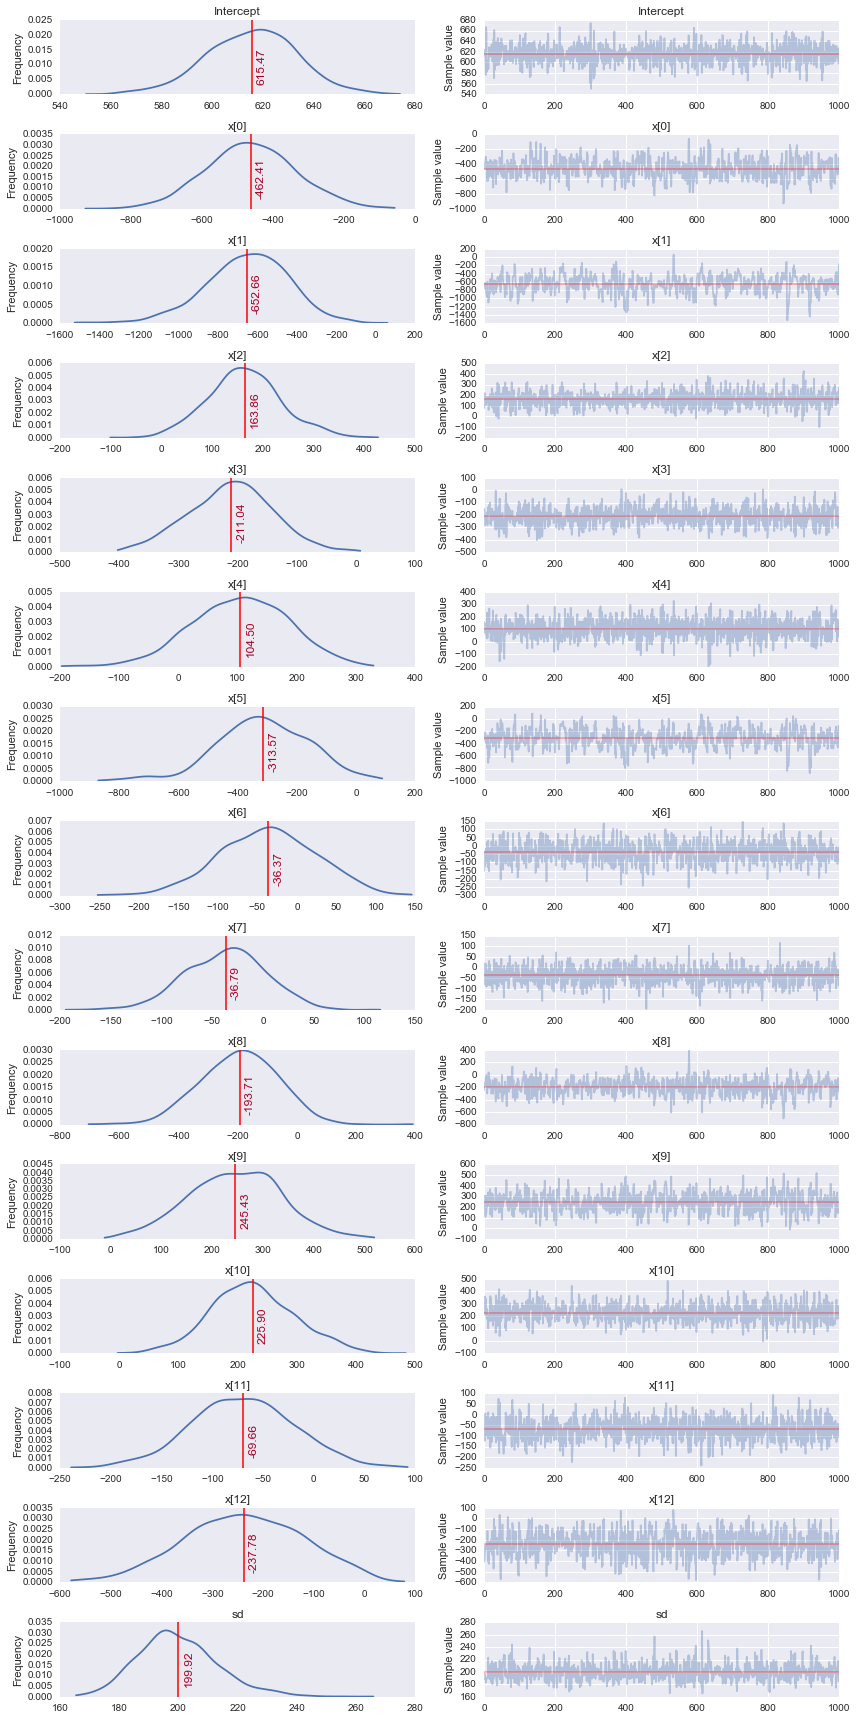

In [15]:
plot_traces(trc_pooled, retain=1000)


In [16]:
pm.df_summary(trc_pooled[-1000:])


,mean,sd,mc_error,hpd_2.5,hpd_97.5
Intercept,615.467101,17.923924,0.525077,579.271921,650.861323
x[0],-462.408999,127.561086,6.043619,-710.866804,-213.511636
x[1],-652.660929,215.362359,12.931902,-1098.837136,-261.842860
x[2],163.858288,72.759881,2.130900,30.089546,320.103643
x[3],-211.036129,71.176590,2.580432,-344.413762,-66.163183
x[4],104.497446,81.617811,2.363708,-47.430854,267.743837
x[5],-313.571410,156.406661,9.009294,-582.423708,39.818682
x[6],-36.369311,61.625574,2.260114,-149.307711,87.786699
x[7],-36.792000,40.440206,1.269848,-113.658543,39.191325
x[8],-193.707415,130.560478,6.058754,-437.126414,49.074100


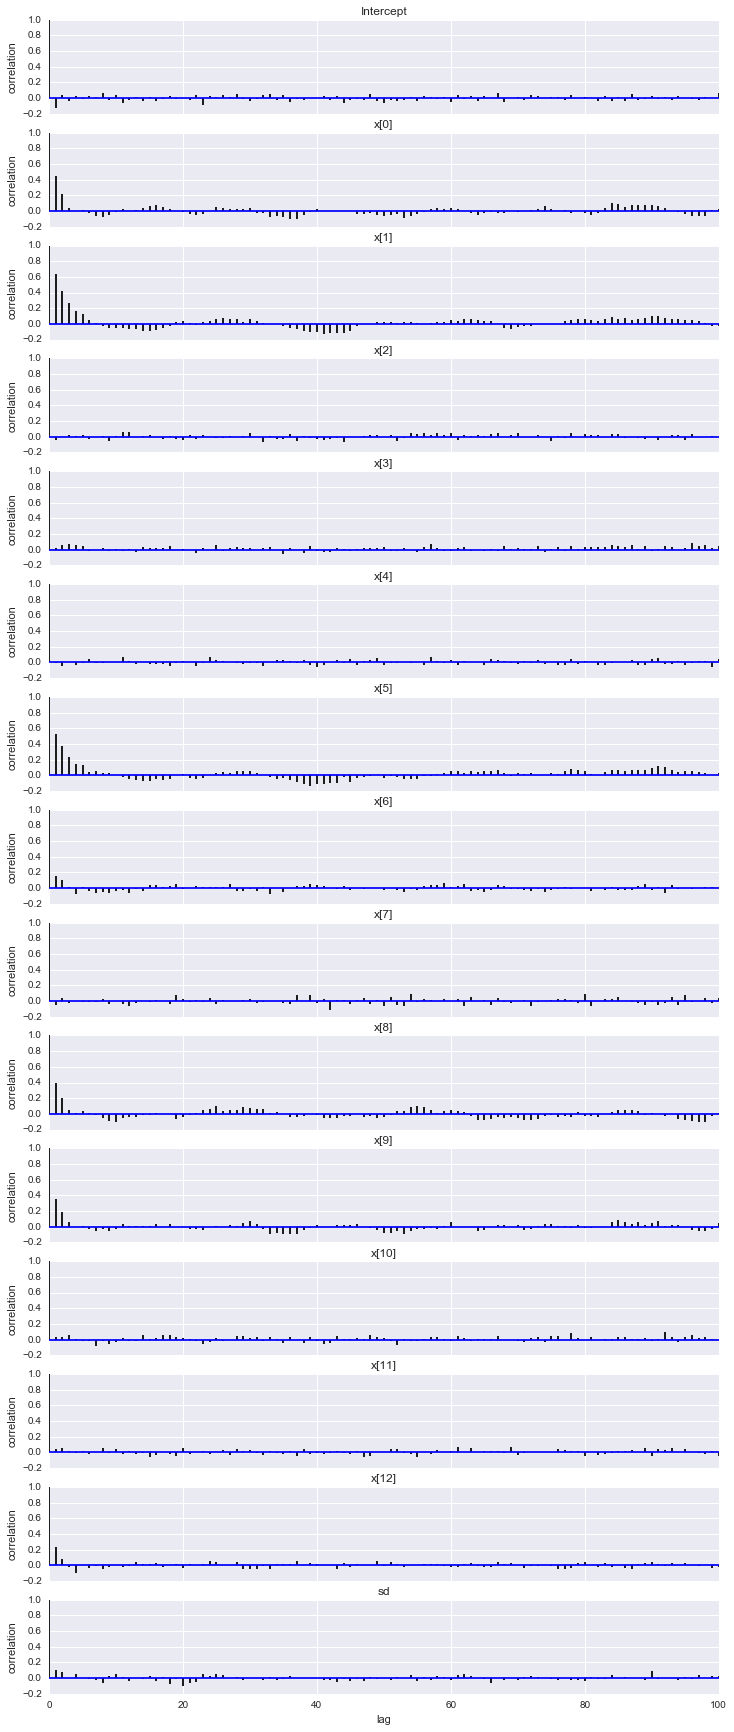

In [17]:
ax = pm.autocorrplot(trc_pooled[-1000:])


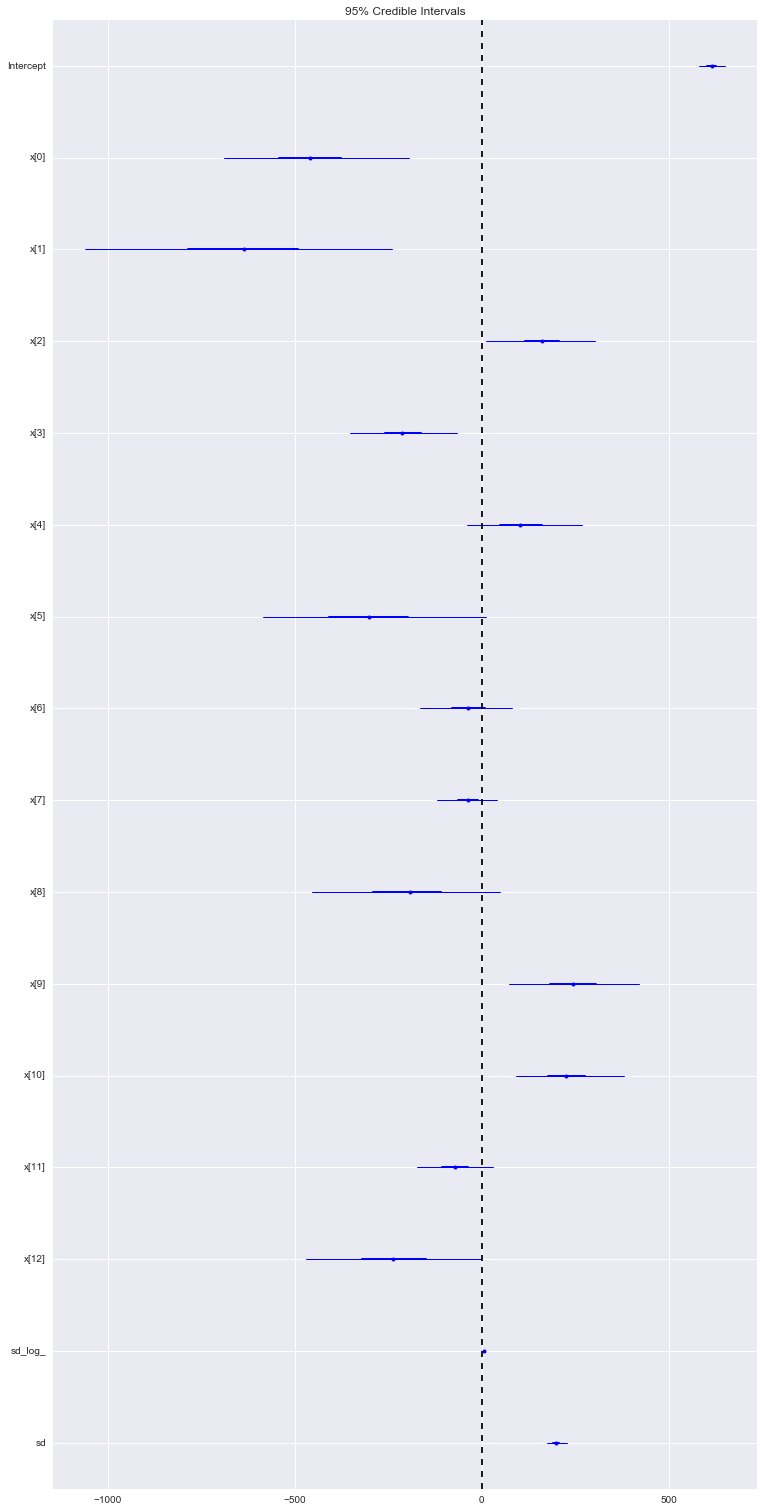

In [18]:
plt.figure(figsize=(12, 24))
pm.forestplot(trc_pooled)
# plt.savefig('../../Downloads/forestplot.png', dpi=400)
# plt.xlim(-1000, 1000)


In [52]:
ppc_pooled = pm.sample_ppc(trc_pooled[-1000:], samples=500, model=mdl_pooled, size=50)
y_pred1 = ppc_pooled['y'].mean(0).mean(0).T
print 'Train_RMSE: {0}'.format(np.sqrt(mean_squared_error(y_train, y_pred1)))
print 'Train_R2: {0}'.format(r2_score(y_train, y_pred1))

Train_RMSE: 188.638259085
Train_R2: 0.506136910542


In [22]:
pm.stats.waic(model=mdl_pooled, trace=trc_pooled[-1000:])

//anaconda/lib/python2.7/site-packages/pymc3/stats.py:138: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


1806.4340878707594

(0, 1200)

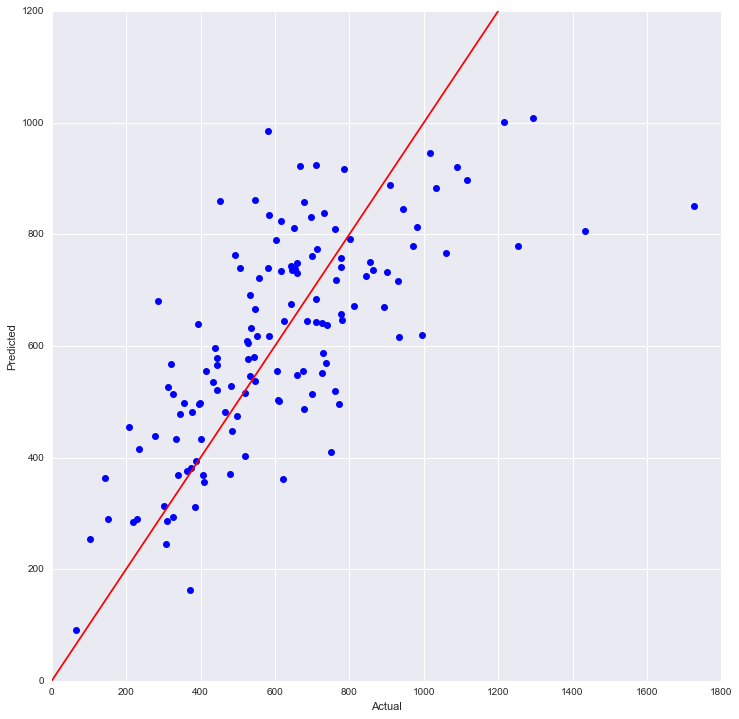

In [24]:
y_pred1 = ppc_pooled['y'].mean(0).mean(0).T
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
ax.plot(y_train, y_pred1, 'ko', color='blue')
ax.plot([0, 1800], [0,1800], color = 'red')
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_xlim([0, 1800])
ax.set_ylim([0, 1200])


In [25]:
parm_pooled = pm.df_summary(trc_pooled[-1000:]).values

In [26]:
y_pred2 = parm_pooled[0,0] + np.dot(X_lasso_train_std.values, parm_pooled[1:-1,0])

(0, 1200)

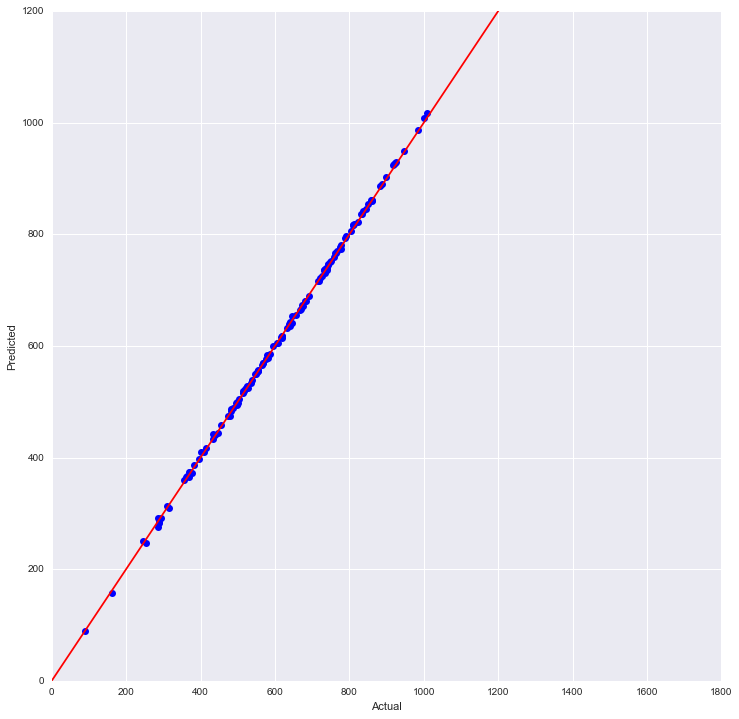

In [27]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
ax.plot(y_pred1, y_pred2, 'ko', color='blue')
ax.plot([0, 1800], [0,1800], color = 'red')
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_xlim([0, 1800])
ax.set_ylim([0, 1200])

In [28]:
x = pd.concat((X_lasso_train_std, X_train['Reservoir_Code']), axis=1)
x.columns


Index([u'Clusters/Stage', u'Perfs/Cluster', u'#_of_Stages', u'ISIP/Ft',
       u'Rate/Ft', u'Rate/Perf', u'Avg_Prop_Conc', u'Max_Prop_Conc',
       u'Rate/Cluster', u'Max_Rate', u'Avg_Pressure', u'Max_Pressure',
       u'Fluid_Gal/Perf', u'Reservoir_Code'],
      dtype='object')

In [ ]:
with pm.Model() as mdl_reservoir:
    
    # define hyperpriors for group nodes
    mu_b0 = pm.Normal('mu_b0', mu=0., sd=100)
    sigma_b0 = pm.Uniform('sigma_b0', lower=0, upper=100)
    mu_b1 = pm.Normal('mu_b1', mu=0., sd=100)
    sigma_b1 = pm.Uniform('sigma_b1', lower=0, upper=100)
    mu_b2 = pm.Normal('mu_b2', mu=0., sd=100)
    sigma_b2 = pm.Uniform('sigma_b2', lower=0, upper=100)
    mu_b3 = pm.Normal('mu_b3', mu=0., sd=100)
    sigma_b3 = pm.Uniform('sigma_b3', lower=0, upper=100)
#     mu_b4 = pm.Normal('mu_b4', mu=0., sd=100)
#     sigma_b4 = pm.Uniform('sigma_b4', lower=0, upper=100)
#     mu_b5 = pm.Normal('mu_b5', mu=0., sd=100)
#     sigma_b5 = pm.Uniform('sigma_b5', lower=0, upper=100)
#     mu_b6 = pm.Normal('mu_b6', mu=0., sd=100)
#     sigma_b6 = pm.Uniform('sigma_b6', lower=0, upper=100)
#     mu_b7 = pm.Normal('mu_b7', mu=0., sd=100)
#     sigma_b7 = pm.Uniform('sigma_b7', lower=0, upper=100)
#     mu_b8 = pm.Normal('mu_b8', mu=0., sd=100)
#     sigma_b8 = pm.Uniform('sigma_b8', lower=0, upper=100)
#     mu_b9 = pm.Normal('mu_b9', mu=0., sd=100)
#     sigma_b9 = pm.Uniform('sigma_b9', lower=0, upper=100)
#     mu_b10 = pm.Normal('mu_b10', mu=0., sd=100)
#     sigma_b10 = pm.Uniform('sigma_b10', lower=0, upper=100)
#     mu_b11 = pm.Normal('mu_b11', mu=0., sd=100)
#     sigma_b11 = pm.Uniform('sigma_b11', lower=0, upper=100)
#     mu_b12 = pm.Normal('mu_b12', mu=0., sd=100)
#     sigma_b12 = pm.Uniform('sigma_b12', lower=0, upper=100)
#     mu_b13 = pm.Normal('mu_b13', mu=0., sd=100)
#     sigma_b13 = pm.Uniform('sigma_b13', lower=0, upper=100)

    # define priors, use Normal
    b0 = pm.Normal('b0_Reservoir_Code', mu=mu_b0, sd=sigma_b0, shape=x['Reservoir_Code'].nunique())
    b1 = pm.Normal('b1_Clusters/Stage', mu=mu_b1, sd=sigma_b1, shape=x['Reservoir_Code'].nunique())
    b2 = pm.Normal('b2_Perfs/Cluster', mu=mu_b2, sd=sigma_b2, shape=x['Reservoir_Code'].nunique())
    b3 = pm.Normal('b3_#_of_Stages', mu=mu_b3, sd=sigma_b3, shape=x['Reservoir_Code'].nunique())
    b4 = pm.Normal('b4_ISIP/Ft', mu=0, sd=100)
    b5 = pm.Normal('b5_Rate/Ft', mu=0, sd=100)
    b6 = pm.Normal('b6_Rate/Perf', mu=0, sd=100)
    b7 = pm.Normal('b7_Avg_Prop_Conc', mu=0, sd=100)
    b8 = pm.Normal('b8_Max_Prop_Conc', mu=0, sd=100)
    b9 = pm.Normal('b9_Rate/Cluster', mu=0, sd=100)
    b10 = pm.Normal('b10_Max_Rate', mu=0, sd=100)
    b11 = pm.Normal('b11_Avg_Pressure', mu=0, sd=100)
    b12 = pm.Normal('b12_Max_Pressure', mu=0, sd=100)    
    b13 = pm.Normal('b13_Fluid_Gal/Perf', mu=0, sd=100)    
    
    # define model error
    epsilon = pm.Uniform('eps', lower=0, upper=100)
    
    # define linear model
    y =    ( b0[x['Reservoir_Code']] +
             b1[x['Reservoir_Code']] * x['Clusters/Stage'] + 
             b2[x['Reservoir_Code']] * x['Perfs/Cluster'] +
             b3[x['Reservoir_Code']] * x['#_of_Stages'] +
             b4 * x['ISIP/Ft'] +
             b5 * x['Rate/Ft'] +
             b6 * x['Rate/Perf'] +
             b7 * x['Avg_Prop_Conc'] +
             b8 * x['Max_Prop_Conc'] +
             b9 * x['Rate/Cluster'] +
             b10 * x['Max_Rate'] +
             b11 * x['Avg_Pressure'] +
             b12 * x['Max_Pressure'] +
             b13 * x['Fluid_Gal/Perf'])

    ## Likelihood (sampling distribution) of observations
    likelihood = pm.Normal('likelihood', mu=y, sd=epsilon, observed=y_train)
 
    # run model
    step = pm.NUTS()
    start = pm.find_MAP()
    trace = pm.backends.Text('../other/traces_txt/trc_reservoir')
    trc_reservoir = pm.sample(2000, njobs=1, step=step, start=start, trace=trace)     


Applied interval-transform to sigma_b0 and added transformed sigma_b0_interval_ to model.
INFO:pymc3:Applied interval-transform to sigma_b0 and added transformed sigma_b0_interval_ to model.
Applied interval-transform to sigma_b1 and added transformed sigma_b1_interval_ to model.
INFO:pymc3:Applied interval-transform to sigma_b1 and added transformed sigma_b1_interval_ to model.
Applied interval-transform to sigma_b2 and added transformed sigma_b2_interval_ to model.
INFO:pymc3:Applied interval-transform to sigma_b2 and added transformed sigma_b2_interval_ to model.
Applied interval-transform to sigma_b3 and added transformed sigma_b3_interval_ to model.
INFO:pymc3:Applied interval-transform to sigma_b3 and added transformed sigma_b3_interval_ to model.
Applied interval-transform to eps and added transformed eps_interval_ to model.
INFO:pymc3:Applied interval-transform to eps and added transformed eps_interval_ to model.

  6%|▌         | 117/2000 [01:06<31:35,  1.01s/it]

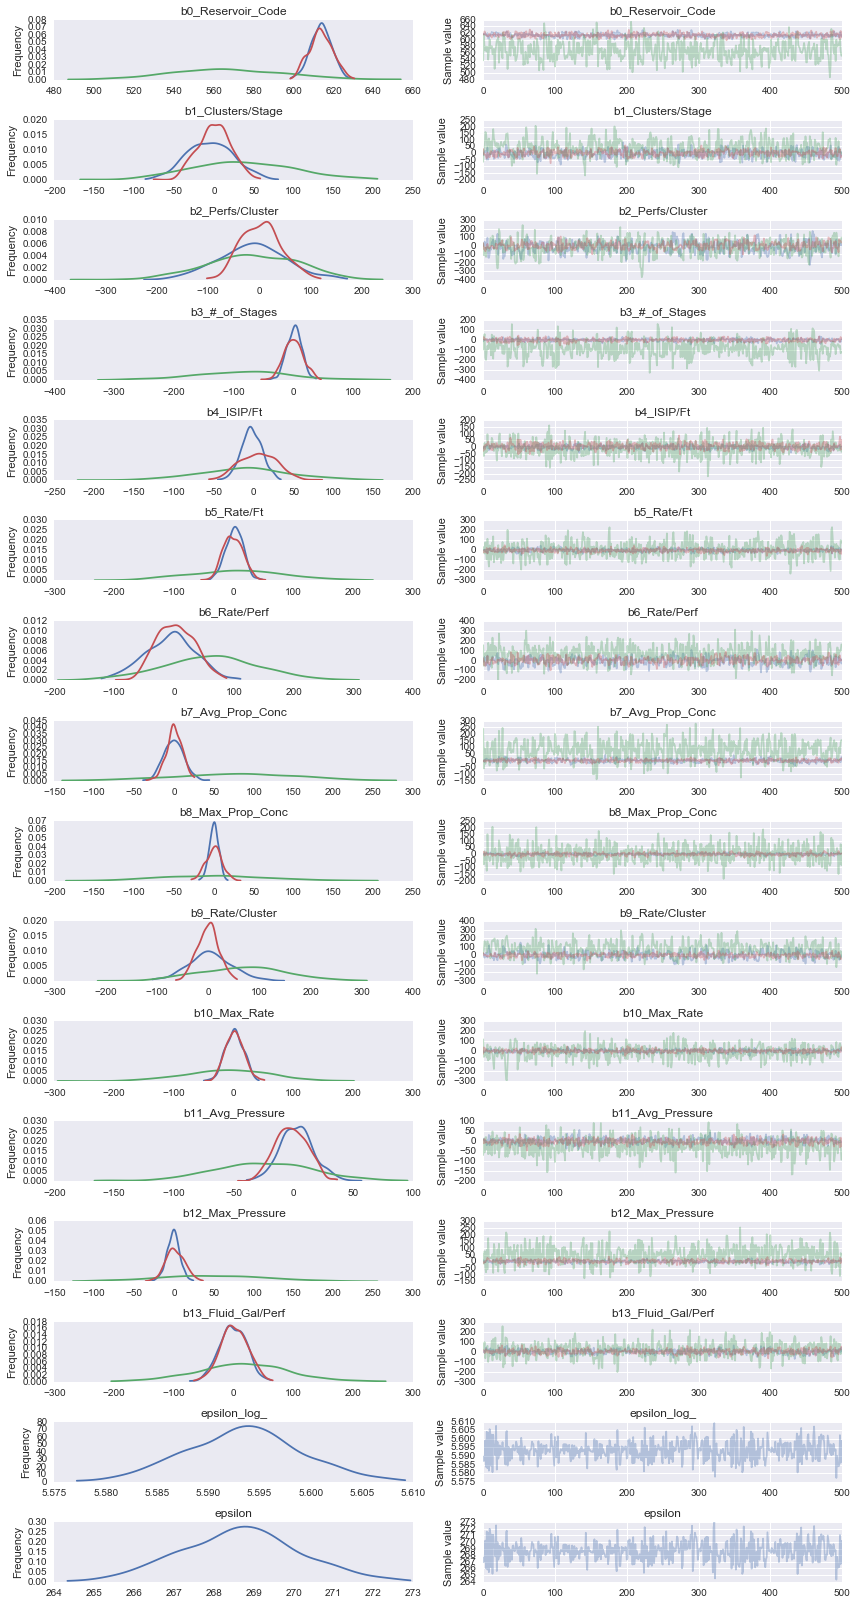

In [30]:
rvs_reservoir = [rv.name for rv in mdl_reservoir.unobserved_RVs]
ax = pm.traceplot(trc_reservoir[-500:], varnames=rvs_reservoir, figsize=(12,len(rvs_reservoir)*1.4), combined=False)


In [31]:
pm.df_summary(trc_reservoir[-500:])

,mean,sd,mc_error,hpd_2.5,hpd_97.5
b0_Reservoir_Code__0,613.802136,5.288248,0.230900,603.642176,624.489699
b0_Reservoir_Code__1,567.058212,27.998147,1.424882,510.063999,618.504795
b0_Reservoir_Code__2,613.691550,5.882662,0.243027,602.686718,624.797644
b1_Clusters/Stage__0,-4.928657,28.866988,1.179145,-53.685582,58.490673
b1_Clusters/Stage__1,36.411284,63.745105,3.445538,-83.561857,159.021057
b1_Clusters/Stage__2,0.632315,20.363075,0.922921,-36.242285,40.699237
b2_Perfs/Cluster__0,-14.257264,66.319231,3.607673,-156.585808,111.386467
b2_Perfs/Cluster__1,-14.563671,91.119489,4.385128,-186.211449,152.602190
b2_Perfs/Cluster__2,3.660211,39.304612,2.179147,-62.198926,85.807762
b3_#_of_Stages__0,0.826769,12.590672,0.493620,-22.220193,23.961276


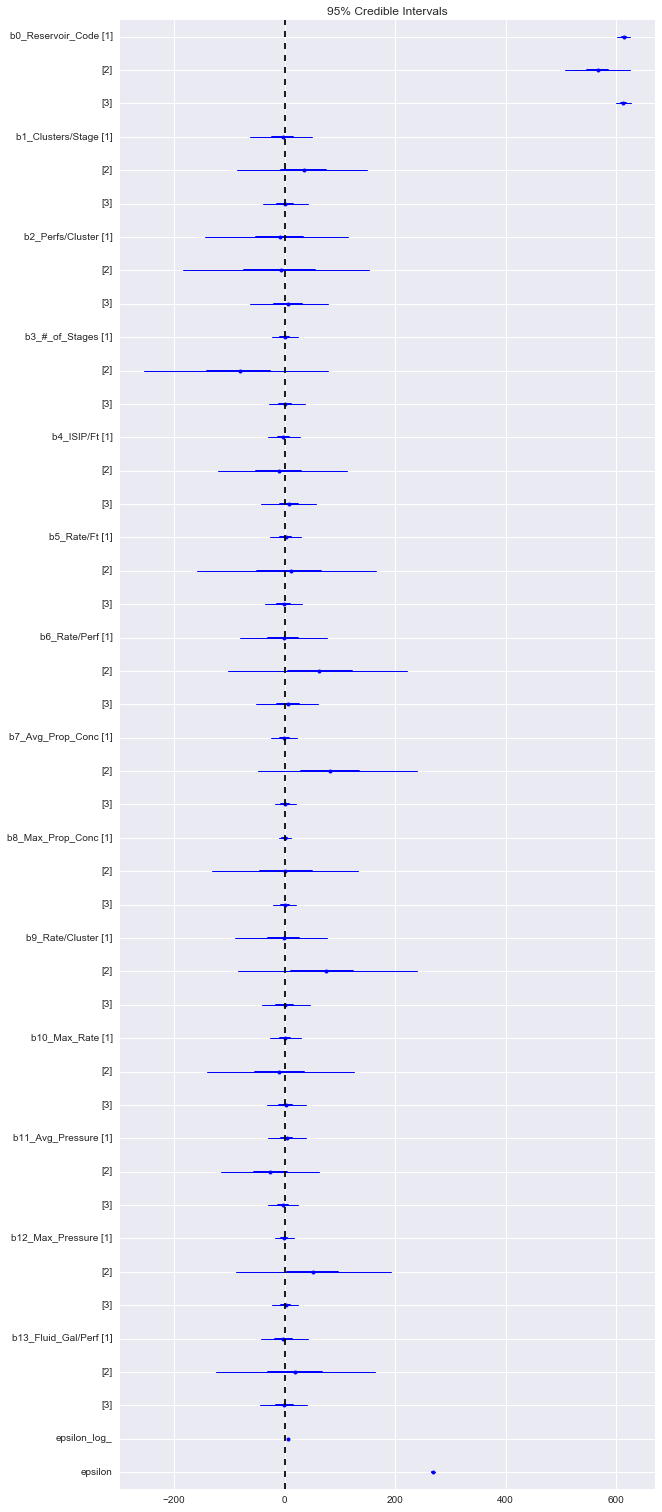

In [33]:
plt.figure(figsize=(12, 24))
pm.forestplot(trc_reservoir)


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:24: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


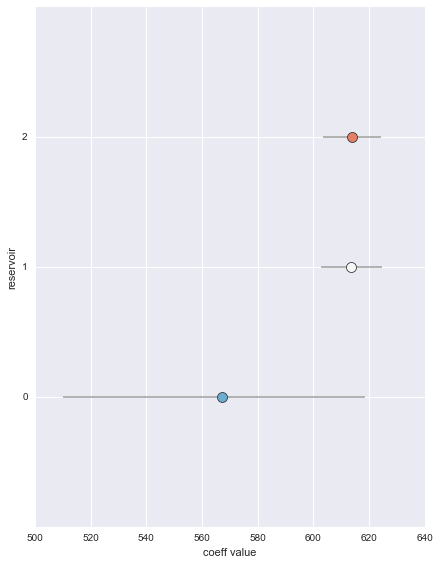

In [36]:
dfsm_reservoir_field = create_smry(trc_reservoir[-500:], X_train, 'Reservoir_Code')
custom_forestplot(dfsm_reservoir_field)


In [37]:
X_train.groupby(['Reservoir_Code'])['Reservoir_Code'].count()


Reservoir_Code
0    69
1     9
2    55
Name: Reservoir_Code, dtype: int64

In [39]:
ppc_reservoir = pm.sample_ppc(trc_reservoir[-500:], samples=500, model=mdl_reservoir, size=50)
y_pred_reservoir = ppc_reservoir['likelihood'].mean(axis=1).mean(axis=0)

In [42]:
y_pred_reservoir

array([ 615.17135157,  617.72658039,  613.44696357,  614.38928021,
        613.70677633,  613.47001784,  615.05224467,  616.40709332,
        615.94875693,  615.98590808,  618.08441792,  613.38277477,
        612.68554456,  615.45421964,  615.01898454,  612.31905538,
        603.22797317,  614.64571573,  614.04421954,  613.48513501,
        616.74977716,  614.71983046,  617.17554211,  612.95615536,
        610.99350282,  612.78229564,  614.40708893,  615.02255565,
        613.42436385,  616.55092228,  615.96753613,  613.61832783,
        613.94140263,  614.85705193,  615.64054801,  613.91001438,
        615.67882406,  613.43202299,  616.44151897,  615.29933767,
        613.18973174,  617.46185908,  616.61760016,  611.10159659,
        612.33585325,  618.13381419,  617.25501898,  618.87603178,
        617.65842908,  613.69569591,  612.0325148 ,  614.1987896 ,
        610.98147071,  616.68413952,  612.50357628,  614.98211516,
        612.29053963,  616.5679851 ,  608.13237591,  613.26850